In [54]:
import json
import math
import sqlite3
import unicodedata
from matplotlib import pyplot as plt
from collections import Counter, defaultdict
from functools import lru_cache
plt.style.use('ggplot')

In [55]:
def unicode_normalize(text):
    """Resolve different type of unicode encodings."""
    return unicodedata.normalize('NFD', text)


class FEVERDocumentDatabase():

    def __init__(self,path=None):
        self.path = path
        self.connection = sqlite3.connect(self.path, check_same_thread=False)

    def __enter__(self):
        return self

    def __exit__(self, *args):
        self.close()

    def path(self):
        """Return the path to the file that backs this database."""
        return self.path

    def close(self):
        """Close the connection to the database."""
        self.connection.close()
        
    @lru_cache(maxsize=100000)
    def get_doc_lines(self, doc_id):
        """Fetch the raw text of the doc for 'doc_id'."""
        cursor = self.connection.cursor()
        cursor.execute(
            "SELECT lines FROM documents WHERE id = ?",
            (unicode_normalize(doc_id),)
        )
        result = cursor.fetchone()
        cursor.close()
        return result if result is None else result[0]

    def get_doc_text(self, doc_id):
        lines = self.get_doc_lines(doc_id)

        if lines is None:
            return None

        lines = lines.split("\n")
        return "\n".join([line.split("\t")[1] for line in lines if len(line.split("\t")) > 1])

    def get_non_empty_doc_ids(self):
        """Fetch all ids of docs stored in the db."""
        cursor = self.connection.cursor()
        cursor.execute("SELECT id FROM documents WHERE length(trim(lines)) > 0")
        results = [r[0] for r in cursor.fetchall()]
        cursor.close()
        return results
    
db = FEVERDocumentDatabase("fever/fever.db")

In [73]:
def read_in(filename):
    tmp = Counter()
    with open(filename) as f:
        for line in f:
            pages = defaultdict(set)
            instance = json.loads(line)
            
            for evidence_group in instance['evidence']:
                for _, _, page, line in evidence_group:

                    if page is not None:
                        pages[page].add(int(line))

                        
            for page,count in pages.items():
                for line_idx,line in enumerate(db.get_doc_lines(page).split("\n")):
                    bits = line.split("\t")
                    if len(bits) > 1 and len(bits[1]):
                        if line_idx in pages[page]:
                            tmp[(line_idx,instance["label"])] += 1
                        else:
                            tmp[(line_idx,"neutral")] += 1
        
        return tmp

def normalize(dist,smooth=1e-6):
    return [(a+smooth)/(sum(dist)+smooth) for a in dist]

def D_kl(p,q):
    return sum(pi*math.log(pi/qi,2) for pi,qi in zip(p,q))
    

In [108]:
labels = Counter()

# labels.update(read_in("fever/train.jsonl"))
labels.update(read_in("fever/shared_task_dev.jsonl"))
              


    

In [121]:
pos = []
val = []
cum_totals_true = [0]
cum_totals_false = [0]

    
for idx in range(50):
    print(labels[(idx,'neutral')],labels[(idx,'SUPPORTS')],labels[(idx,'REFUTES')])
    pos.append(idx)
    val.append([labels[(idx,'neutral')],labels[(idx,'SUPPORTS')],labels[(idx,'REFUTES')]])
    
    
    cum_totals_true += [cum_totals_true[-1] + labels[(idx,'SUPPORTS')]]
    cum_totals_false += [cum_totals_false[-1] + labels[(idx,'REFUTES')]]
    


6936 4315 4765
11721 1358 1456
9743 766 731
7118 459 454
6632 412 451
7461 379 428
7551 414 423
7155 315 262
6535 246 253
6101 248 265
5728 256 231
5239 197 177
4838 189 201
4522 206 211
4457 160 143
4027 158 139
3758 156 129
3195 106 90
2765 66 62
2420 64 56
2255 78 78
2098 51 62
1755 23 38
1490 56 44
1274 51 24
1092 22 13
1099 26 22
873 17 12
692 15 11
636 19 10
553 5 4
440 10 6
357 6 2
338 6 3
346 14 7
241 3 1
222 4 5
194 3 3
241 3 2
199 2 5
176 11 9
97 4 4
93 3 8
133 3 2
104 4 3
78 0 1
63 1 0
54 0 0
72 1 1
71 0 0


[0, 4315, 5673, 6439, 6898, 7310, 7689, 8103, 8418, 8664, 8912, 9168, 9365, 9554, 9760, 9920, 10078, 10234, 10340, 10406, 10470, 10548, 10599, 10622, 10678, 10729, 10751, 10777, 10794, 10809, 10828, 10833, 10843, 10849, 10855, 10869, 10872, 10876, 10879, 10882, 10884, 10895, 10899, 10902, 10905, 10909, 10909, 10910, 10910, 10911, 10911]


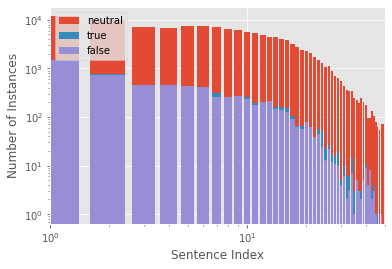

In [111]:
for series in zip(*val):
    plt.bar(pos,series)

plt.xlabel('Sentence Index')
plt.ylabel("Number of Instances")
plt.yscale('log')
plt.xscale('log')
plt.xlim((1,50))
plt.legend(["neutral","true","false"])
plt.savefig("bias_sentence_distribution.pdf",bbox_inches='tight')

[0.6054648450516494, 0.26891036321226264, 0.12562479173608798]

In [166]:
infos = []
master_distribution = [0,0,0]

for idx,dist in zip(pos,val):
    master_distribution[0] += dist[0]
    master_distribution[1] += dist[1]
    master_distribution[2] += dist[2]
    
print(master_distribution)
norm_ms = [a/sum(master_distribution) for a in master_distribution]
norm_ms

[135238, 10911, 11307]


[0.8588939132202011, 0.06929554923280154, 0.07181053754699726]

In [167]:
for idx,dist in zip(pos,val):
    infos.append(D_kl(norm_ms,normalize(dist)))

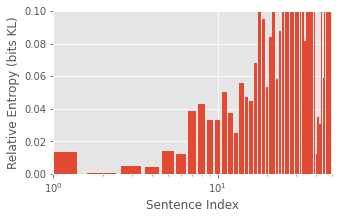

In [168]:
fig= plt.figure(figsize=(5,3))
plt.bar(pos,infos)

plt.autoscale(tight=True)
plt.xscale('log')
plt.ylim((0,0.1))
plt.xlim((1,50))
plt.xlabel("Sentence Index")
plt.ylabel("Relative Entropy (bits KL)")
plt.savefig("bias_sentence_relative_entropy.pdf",bbox_inches='tight')


In [127]:
cum_pos= []
for a,b in zip(cum_totals_true,cum_totals_false):
    cum_pos.append((a+b) / (master_distribution[1]+master_distribution[2]))

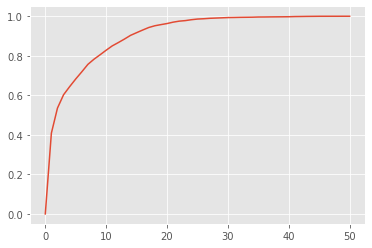

In [130]:
plt.plot(cum_pos)


In [138]:
with open("nc_cumulative_totals.json") as f:
    cum_true_nc,cum_false_nc = json.load(f)
print(cum_true_nc)

[0, 13959, 21635, 26762, 30584, 33534, 36044, 38192, 39972, 41508, 42792, 43886, 44926, 45978, 46849, 47585, 48243, 48814, 49333, 49773, 50156, 50498, 50807, 51088, 51352, 51597, 51822, 52028, 52186, 52335, 52454, 52563, 52659, 52743, 52830, 52908, 52979, 53038, 53086, 53133, 53179, 53224, 53277, 53309, 53345, 53374, 53408, 53441, 53479, 53503, 53522, 53539, 53563, 53584, 53602, 53626, 53641, 53656, 53675, 53692, 53713, 53731, 53740, 53754, 53764, 53777, 53789, 53797, 53802, 53805, 53809, 53812, 53815, 53821, 53826, 53831, 53836, 53840, 53843, 53845, 53846, 53848, 53852, 53852, 53853, 53856, 53859, 53860, 53862, 53864, 53867, 53872, 53874, 53876, 53878, 53880, 53884, 53887, 53888, 53889, 53890, 53890]


In [143]:
cum_pos_nc= []
for a,b in zip(cum_true_nc[:50],cum_false_nc[:50]):
    cum_pos_nc.append((a+b) / (cum_true_nc[-1]+cum_false_nc[-1]))

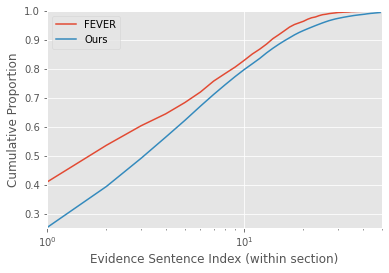

In [163]:
plt.plot(cum_pos[:])
plt.plot(cum_pos_nc[:])
plt.legend(["FEVER","Ours"])

plt.xscale("log")
plt.xlim((1,50))
plt.ylim((0.25,1.0))
plt.xlabel("Evidence Sentence Index (within section)")
plt.ylabel("Cumulative Proportion")
plt.savefig("bias_data_proportion.pdf",bbox_inches='tight')